In [4]:
import pandas as pd

import torch
import numpy as np
from PIL import Image

from models.tiny_vit import tiny_vit_21m_224
from data import build_transform, imagenet_classnames
from config import get_config

## Metadata

In [3]:
metadata = pd.read_csv("../../dataset/styles.csv")
metadata.sample(3)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,productUsageRights
43785,46441,Men,NaN,Watches,Watches,Silver,Winter,2016.0,Casual,Timex Men Sliver Dial Chronograph Watch,Free
36118,24103,Men,Footwear,Flip Flops,Flip Flops,Blue,Fall,2012.0,Casual,Playboy Men Casual Blue Flip Flops,Free
24022,44199,Women,Footwear,Flip Flops,Flip Flops,Brown,Winter,2012.0,Casual,iPanema Women Brown Flip Flops,Limited


## Loading model

In [6]:
config = get_config()


# Build model
model = tiny_vit_21m_224(pretrained=True)
# model.eval()

## Default Infer

In [7]:
"""Model Inference."""

# Load Image
fname = "../../dataset/images/10001.jpg"
image = Image.open(fname)
transform = build_transform(is_train=False, config=config)

# (1, 3, img_size, img_size)
batch = transform(image)[None]

with torch.no_grad():
    logits = model(batch)

# print top-5 classification names
probs = torch.softmax(logits, -1)
scores, inds = probs.topk(5, largest=True, sorted=True)
print('=' * 30)
print(fname)
for score, ind in zip(scores[0].numpy(), inds[0].numpy()):
    print(f'{imagenet_classnames[ind]}: {score:.2f}')

../../dataset/images/10001.jpg
lighter: 0.02
dumbbell: 0.02
plectrum: 0.01
water bottle: 0.01
screwdriver: 0.01


# Single Class Fine Tune

## Gender Prediciton

### define model

In [35]:
model.head = torch.nn.Linear(model.head.in_features, 3)

### create dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        metadata = pd.read_csv(csv_file)
        self.labels_df = metadata[~metadata["id"].isin(worng_shape_images + missing_files)]
        self.img_dir = img_dir
        self.transform = transform
        self.gendermap = {"Boys": 0,
                          "Girls": 1,
                          "Men": 0,
                          "Unisex": 2,
                          "Women": 1,
                         }
        

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.labels_df.iloc[idx, 0])+".jpg")
        image = Image.open(img_name)
        label = self.gendermap[self.labels_df.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert PIL image to tensor
])

# Initialize dataset and dataloader, 
dataset = CustomImageDataset(csv_file="../../dataset/styles.csv", img_dir="../../dataset/images/", transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [86]:
dataset = CustomImageDataset("../../dataset/styles.csv", "../../dataset/images/", transform=None)
# dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

generator = torch.Generator().manual_seed(42)
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2], generator)

train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=5, shuffle=True)

Feature batch shape: torch.Size([5, 3, 80, 60])


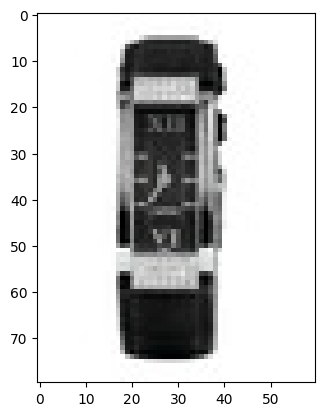

Label: 1


In [87]:
# Display image and label.
features, labels = next(iter(train_dataloader))
print(f"Feature batch shape: {features.size()}")
# print(f"Labels batch shape: {labels.size()}")
img = features[0]#.squeeze()
label = labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

In [88]:
features.shape

torch.Size([5, 3, 80, 60])

In [89]:
metadata.groupby("gender").count()["id"]

gender
Boys        830
Girls       655
Men       22147
Unisex     2161
Women     18631
Name: id, dtype: int64

### train

In [79]:
for batch in train_dataloader:
    print(batch.shape)  # Should print [10, 3, 244, 244] for a batch of 10 images

AttributeError: 'list' object has no attribute 'shape'

In [83]:
len(batch) # [0].shape

2

In [85]:
batch[1]

tensor([0, 0, 1, 0, 0])

# Another Attempt

In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        metadata = pd.read_csv(csv_file)
        self.labels_df = metadata[~metadata["id"].isin(worng_shape_images + missing_files)]
        self.img_dir = img_dir
        self.transform = transform
        self.gendermap = {"Boys": 0,
                          "Girls": 1,
                          "Men": 0,
                          "Unisex": 2,
                          "Women": 1,
                         }
        

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.labels_df.iloc[idx, 0])+".jpg")
        image = Image.open(img_name)
        label = self.gendermap[self.labels_df.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert PIL image to tensor
])

# Initialize dataset and dataloader, 
dataset = CustomImageDataset(csv_file="../../dataset/styles.csv", img_dir="../../dataset/images/", transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [165]:
config = get_config()


# Build model
model = tiny_vit_21m_224(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
model.head = torch.nn.Linear(model.head.in_features, 3)
for param in model.head.parameters():
    param.requires_grad = True
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [166]:
%%time
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    
    for it, (inputs, labels) in enumerate(dataloader):
        if it == 10:
            break
        # inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        print(".", end="")

    epoch_loss = running_loss / len(dataset)
    print(f'\nEpoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')


..........
Epoch 1/10, Loss: 0.0307
..........
Epoch 2/10, Loss: 0.0269
..........
Epoch 3/10, Loss: 0.0245
..........
Epoch 4/10, Loss: 0.0224
..........
Epoch 5/10, Loss: 0.0210
..........
Epoch 6/10, Loss: 0.0197
..........
Epoch 7/10, Loss: 0.0186
..........
Epoch 8/10, Loss: 0.0175
..........
Epoch 9/10, Loss: 0.0172
..........
Epoch 10/10, Loss: 0.0165
CPU times: user 1h 5min 46s, sys: 11min 20s, total: 1h 17min 6s
Wall time: 17min 48s


Feature batch shape: torch.Size([32, 3, 224, 224])


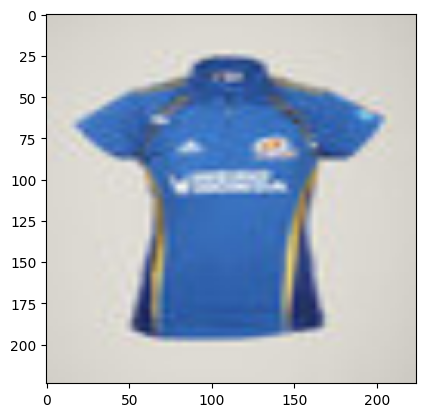

Label: 1


In [102]:
# Display image and label.
features, labels = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
# print(f"Labels batch shape: {labels.size()}")
img = features[0]#.squeeze()
label = labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

In [153]:
from PIL import Image
import os.path

# filename = os.path.join('path', 'to', 'image', 'file')
# img = Image.open(filename)
# print img.size
path = "../../dataset/images/"
counter = 0
worng_shape_images = []
missing_files = []
for image_id in metadata.id.items():
    filepath = path + str(image_id[1]) + ".jpg"
    if not os.path.isfile(filepath):
        missing_files.append(image_id[1])
        continue
    img = np.array(Image.open(filepath))
    if img.ndim != 3:
        # print(f"{filename} :: {img.shape}")
        worng_shape_images.append(image_id[1])

In [150]:
missing_files

[39403, 39410, 39425, 12347, 39401]

In [154]:
worng_shape_images[:5]

[48966, 56597, 21629, 50674, 54143]

In [155]:
metadata[~metadata["id"].isin(worng_shape_images + missing_files)].shape

(43988, 11)

In [118]:
metadata[~ metadata["id"].isin([worng_shape_images])].shape

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,productUsageRights
0,37695,Unisex,Accessories,Bags,Backpacks,Brown,Summer,2012.0,Casual,American Tourister Unisex Brown Backpack,Limited
1,7073,Unisex,Accessories,Bags,Backpacks,Orange,NaN,2015.0,Casual,Wildcraft Unisex Orange & White Printed Backpack,Free
2,28457,Women,Apparel,Bottomwear,Capris,Black,Summer,2012.0,Sports,Urban Yoga Women Black Capris,Free
3,7412,Women,Apparel,Topwear,Kurtas,Pink,Summer,2011.0,Ethnic,W Women V Neck Short Sleeve Pink Kurta,Limited
4,11775,Men,Apparel,Topwear,Tshirts,White,Fall,2011.0,Casual,Lee Men Printed White Tshirts,Free
...,...,...,...,...,...,...,...,...,...,...,...
44419,32618,Men,Apparel,Topwear,Jackets,Black,Summer,2012.0,Sports,Nike Men Black Jacket,Limited
44420,17260,Men,Apparel,Topwear,Tshirts,Cream,Fall,2011.0,Casual,U.S. Polo Assn. Men Solid Ivory Polo Tshirt,Restricted
44421,6735,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Puma Men Mid CVS Navy Blue Shoes,Restricted
44422,43002,Men,Footwear,Shoes,Sports Shoes,Grey,Summer,2012.0,Sports,Nike Men Grey Lunarswift Sports Shoes,Restricted
